# Report - Assignment 1

### Videsh Suman (150040095)

In [1]:
# HEADER FILES
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from sklearn.cross_validation import cross_val_score
matplotlib.style.use('ggplot')
%matplotlib inline 
# special matplotlib argument for improved plots

/Users/sumanvid97/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


###### Reading train.csv and finding out it's shape.

In [2]:
df = pd.read_csv('train.csv') # read train data

# sets the index corresponding to the "Id" column
df.set_index('Id', inplace=True) 

print (df.shape) # prints the shape of dataframe

(1460, 32)


### Data Preprocessing:

###### Imputing the missing values case by case.
- Missing values in categorical features filled with most appropriate already existing categories like 'None' or 'NA'
- Filling the missing numerical values with 0 or median, depending upon the feauture

In [3]:
# HANDLING MISSING VALUES

df["GarageType"].fillna("NA", inplace=True)

# Imputing median year values, so that the imputed values do not affect the variance much.
df["GarageYrBlt"].fillna(df["GarageYrBlt"].median(), inplace=True)
                         
df["GarageFinish"].fillna("NA", inplace=True)
df["MasVnrType"].fillna("None", inplace=True)
                         
# Imputing area=0 since the MasVnrType doesn't exist
df["MasVnrArea"].fillna(0, inplace=True)

###### Separating out the feature variables from the dataframe, assigning them respective datatypes.
- All the numerical features should be floating, so that they can be scaled later
- Changing the datatype of categorical features from object to category to avoid inconvenience later

In [4]:
Y = df.iloc[:, len(df.columns)-1] # TARGET -> SaleStatus
X = df.iloc[:, 0:len(df.columns)-1] # FEATURES -> MSSubClass to SaleCondition

# print (pd.isnull(X).sum())

# Type Conversion: int64 -> float64, object -> category
for col in X.columns.values:
    if X[col].dtype == 'int64':
        X[col] = X[col].astype('float64')
    if X[col].dtype == object:
        X[col] = X[col].astype('category')
        
# The MS subclasses are actually categories
X["MSSubClass"] = X["MSSubClass"].astype('category')

# print (X.dtypes)

###### Normalizing and standardizing the numerical features, as a part of feature scaling.
- Min-max Scaling: entire column is fitted within the range of [0,1]
- Standardization: mean = 0, std. deviation = 1

In [5]:
# FEATURE SCALING OF NUMERICAL DATA
# Min-max scaling and Standardized scaling
for col in X.columns.values:
    if X[col].dtypes == 'float64':
        X[col] = (X[col] - X[col].min())/(X[col].max() - X[col].min()) 
        X[col] = (X[col] - X[col].mean())/X[col].std() 
        
# print (X)

###### Implementing one hot encoding for categorical variables to binarize these categories of each feature.
- This way the categories are rendered comepletely unordered as they actually are.
- Learning becomes more accurate, though less convenient due to too many features.

In [6]:
# ONE HOT ENCODING FOR CATEGORICAL FEATURES
# creating dummies
X = pd.get_dummies(X, columns = X.select_dtypes(include=['category'])) 

# extra feature occuring in one hot encoded TEST data file 
X['MSSubClass_150.0'] = 0 

# print (X.columns.values) # Final Shape of X

##### Note:
Technically, train.csv and test.csv should be preprocessed together, after concatenating the two dataframes. However, due to the constraint of the assignment, train.csv has been read in train.py, while test.csv in test.py. So, both of these dataframes have been preprocessed independently due to which the number of features, after One Hot Encoding in each file, produced some difference. These extra features(as columns of zeros) have been added accordingly to both the feature dataframes after examining them closely. This constraint has also affected the normalization and standardization steps, not very significantly though.

##### Data Preprocessing Strategies
- Imputation of missing values, otherwise they would have created a problem later 
- Feature scaling of numerical variables, required for 
- Tried plotting the correlation curves amongst the features, however they didn't give much information about the features
- One hot encoding of the nominal features, instead of categorical encoding for each feature
- Former gives no bias to any particular category, unlike the latter that gives rise to some kind of order among the categories within a feature
- However, this gave sudden rise to the dimensionality of X, requiring a significant training time, but creating a more robust model eventually
- Never tried any kind of feature selection, not wanting to compromise on the robustness
- The tree algorithms(Decision Tree, Random Forest) in scikit learn have a default value for max_features of sqrt(total features), selection of which is based on their individual importance

### Model Development:


###### Training - 80%, Testing - 20%


In [7]:
# TRAIN-TEST SPLIT WITHIN THE TRAIN.CSV DATA

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state = 1)

###### The following code block has been picked up from the scikit learn documentation.

In [8]:
# CONFUSION MATRIX PLOT FUNCTION
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###### Function for Hyperparameter Tuning using Cross Validation Plots 
Plot of validation scores w.r.t. the sequence of each hyperparameter put up for tuning

In [9]:
def tuning_cv_plot(clf, parameter, param_range, index):
    fold = KFold(len(Y_train), n_folds=5, shuffle=True, random_state=5)
    gs_clf = GridSearchCV(clf, param_grid={parameter: param_range}, cv=fold)
    gs_clf.fit(X_train, Y_train) 
    score_values = gs_clf.cv_results_['mean_test_score'] # the mean CV score
    plt.figure(figsize=(12,10))
    plt.subplot(3, 2, index)
    plot = plt.plot(param_range, score_values)
    plt.xlabel(parameter)
    plt.ylabel('scores')
    plt.show()
    print('Tuned Value: ', gs_clf.best_params_) # highest tuned
    return gs_clf

##### LOGISTIC REGRESSION
- L2 Regularization
- C : Inverse of regularization strength

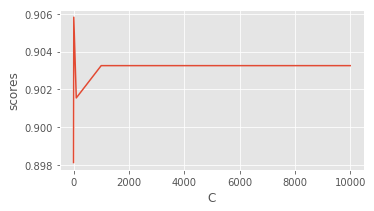

Tuned Value:  {'C': 10.0}


In [10]:
# LOGISTIC REGRESSION

grid = {'C': np.power(10.0, np.arange(0, 5))} # grid of hyperparameters
logreg = LogisticRegression(solver='newton-cg', 
                            penalty='l2', random_state=8, 
                            max_iter=10000, tol=10) # raw classifier
gs_logreg = tuning_cv_plot(logreg, 'C', 
                           np.power(10.0, np.arange(0, 5)), 1) # plotting function

In [11]:
# MODEL ACCURACY
print ('Mean CV Training Accuracy: ', gs_logreg.best_score_) 
Y_pred_logreg = gs_logreg.predict(X_test) # Predicted Y corresponding to X_test
print ('Testing Accuracy:', gs_logreg.score(X_test, Y_test))

Mean CV Training Accuracy:  0.905821917808
Testing Accuracy: 0.893835616438


Confusion Matrix
[[  0   3   1]
 [  0 116  13]
 [  0  14 145]]


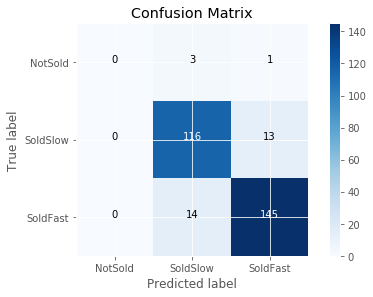

In [12]:
# CONFUSION MATRIX PLOT

class_names = ["NotSold", "SoldSlow", "SoldFast"]

cnf_matrix = confusion_matrix(Y_test, Y_pred_logreg)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')
plt.show()

In [13]:
# EXPORTING MODEL.PKL

joblib.dump(gs_logreg, 'logistic_regression.pkl') 

['logistic_regression.pkl']

###### Final Accuracy of Logistic Regression: 89.38%

##### K NEAREST NEIGHBORS CLASSIFIER
- Classification is computed from a simple majority vote of the nearest neighbors of each point.
- n_neighbors : number of nearest neighbors to be considered for majority deduction

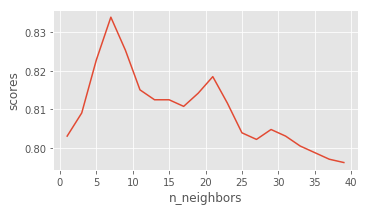

Tuned Value:  {'n_neighbors': 7}


In [14]:
# K NEAREST NEIGHBORS

grid = {'n_neighbors': np.arange(1, 41, 2)} # tuning parameters
knn = KNeighborsClassifier() # raw classifier

gs_knn = tuning_cv_plot(knn, 'n_neighbors', np.arange(1, 41, 2), 1)

In [15]:
# MODEL ACCURACY
print ('Mean CV Training Accuracy: ', gs_knn.best_score_)
Y_pred_knn = gs_knn.predict(X_test) 
print ('Testing Accuracy:', gs_knn.score(X_test, Y_test))

Mean CV Training Accuracy:  0.833904109589
Testing Accuracy: 0.825342465753


Confusion Matrix
[[  0   3   1]
 [  0 116  13]
 [  0  14 145]]


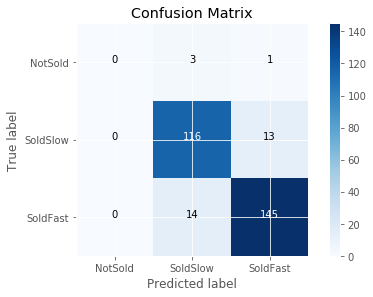

In [16]:
# CONFUSION MATRIX PLOT

cnf_matrix = confusion_matrix(Y_test, Y_pred_logreg)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')
plt.show()

In [17]:
# EXPORTING MODEL.PKL

joblib.dump(gs_knn, 'k_nearest_neighbors.pkl') 

['k_nearest_neighbors.pkl']

###### Final Accuracy of K Nearest Neighbors: 82.53%

##### DECISION TREE CLASSIFIER
- criterion : Gini Impurity("gini") or Information Gain("entropy")
- min_samples_split : minimum number of samples required to split an internal node
- max_depth : maximum depth of the tree
- min_samples_leaf : minimum number of samples required to be at a leaf node
- max_leaf_nodes : constraint of maximum leaf nodes for the tree to grow in best-first fashion

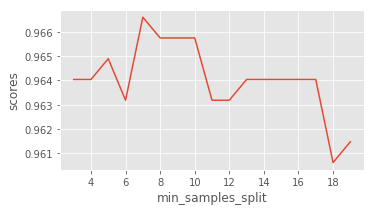

Tuned Value:  {'min_samples_split': 7}


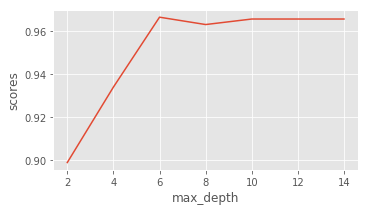

Tuned Value:  {'max_depth': 6}


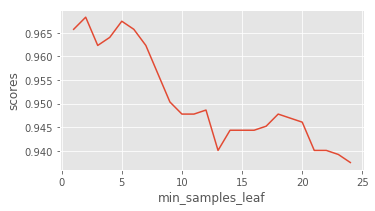

Tuned Value:  {'min_samples_leaf': 2}


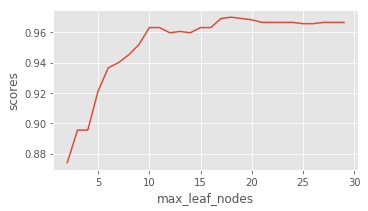

Tuned Value:  {'max_leaf_nodes': 18}


''

In [18]:
# DECISION TREE

grid = {"min_samples_split": np.arange(3, 20, 1),
        "max_depth": np.arange(2, 16, 2),
        "min_samples_leaf": np.arange(1, 25, 1),
        "max_leaf_nodes": np.arange(2, 30, 1)}
dtree = DecisionTreeClassifier(criterion="entropy", random_state=8) # raw model

# visualizing the hyperparameters one at a time against the mean CV accuracy
index = 1
for parameter, param_range in dict.items(grid): 
    tuning_cv_plot(dtree, parameter, param_range, index) # plotting-function defined previously
    index += 1
;

###### Plot insights: 
- min_samples_split : haphazard nature, though slightly higher scores in the middle
- max_depth : increases initially, and then becomes almost constant
- min_samples_leaf : haphazard, but overall deeacrasing
- max_leaf_nodes : increasing, then becomes nearly constant

In [19]:
# Redefining the model with the tuned parameters
fold = KFold(len(Y_train), n_folds=5, shuffle=True, random_state=5) # 5 folds
dtree = DecisionTreeClassifier(random_state=8, criterion="entropy",
                                min_samples_split=12, max_depth=8,
                                min_samples_leaf=5, max_leaf_nodes=21)
dtree.fit(X_train, Y_train)
scores_dtree = cross_val_score(dtree, X_train, Y_train, cv=fold)
scores_dtree

array([ 0.97,  0.97,  0.98,  0.97,  0.94])

In [20]:
# MODEL ACCURACY 

print ('Mean CV Training Accuracy: ', scores_dtree.mean())
Y_pred_dtree = dtree.predict(X_test) # Predicted Y corresponding to X_test
print ('Testing Accuracy:', dtree.score(X_test, Y_test))

Mean CV Training Accuracy:  0.964876563589
Testing Accuracy: 0.972602739726


##### TREE VISUALIZER 
Very complex due to the high dimensionality of X, but quite insightful if observed carefully.

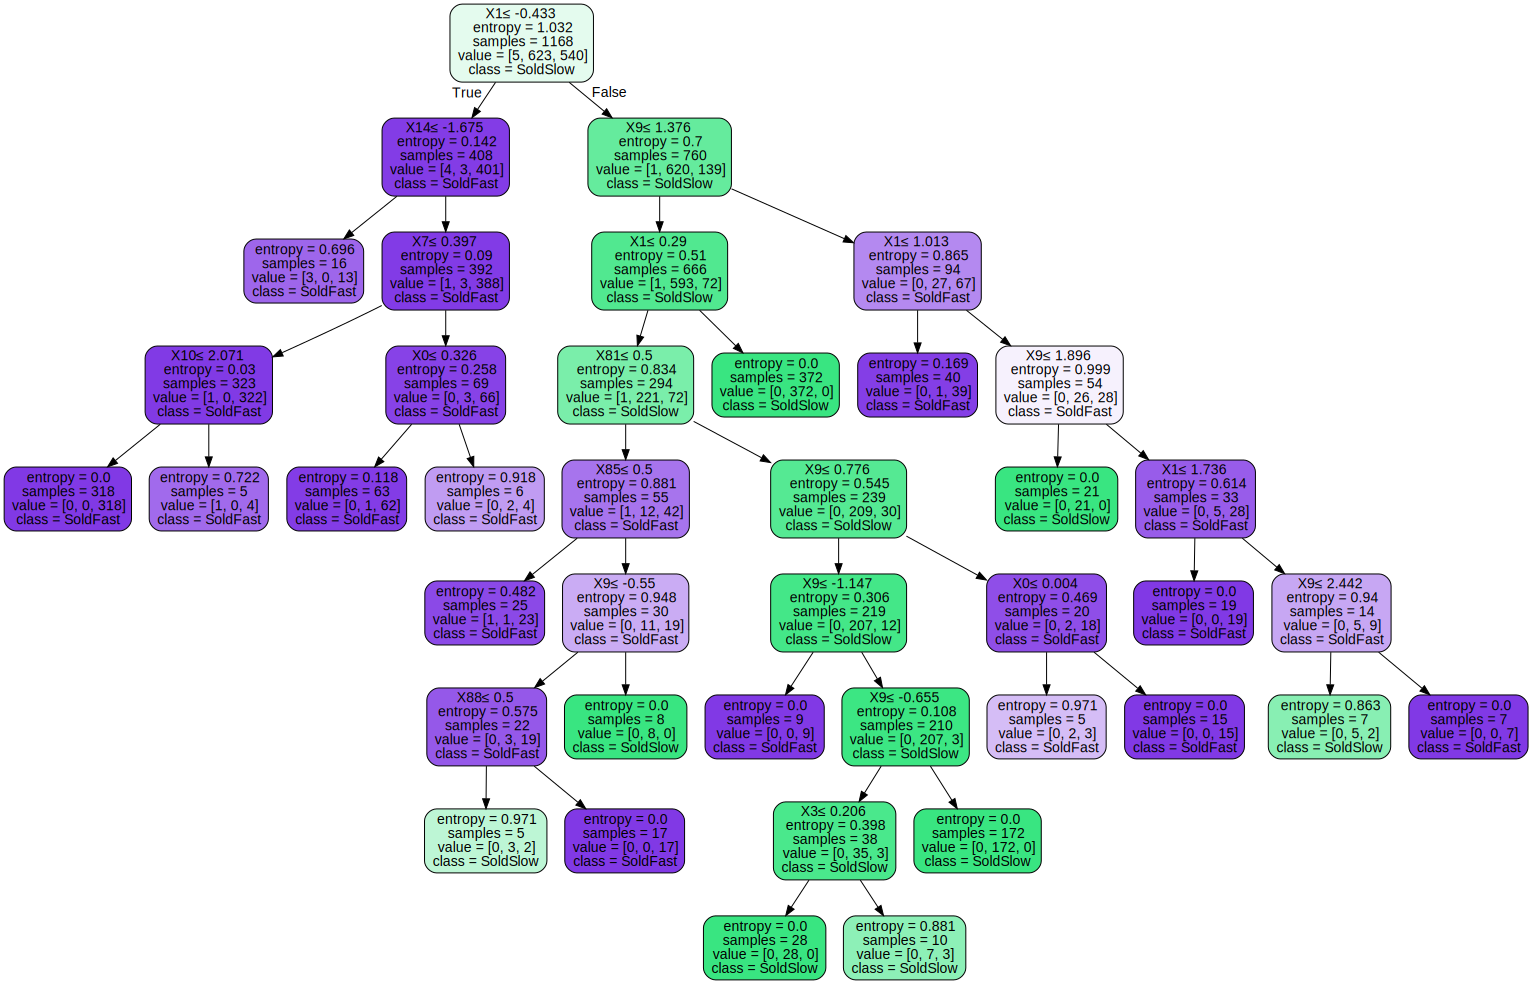

In [21]:
# TREE VISUALIZER
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dtree, out_file=None,   
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Confusion Matrix
[[  0   3   1]
 [  0 127   2]
 [  0   2 157]]


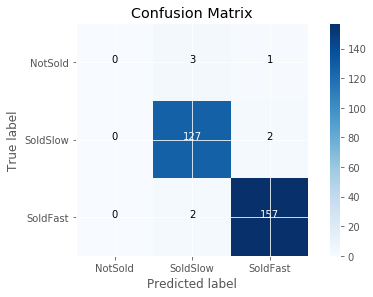

In [22]:
# CONFUSION MATRIX

cnf_matrix = confusion_matrix(Y_test, Y_pred_dtree)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')
plt.show()

In [23]:
# EXPORTING MODEL.PKL

joblib.dump(dtree, 'decision_tree.pkl') 

['decision_tree.pkl']

###### Final Accuracy of Decision Tree Classifier: 97.26%

##### RANDOM FOREST CLASSIFIER
A meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset, and uses averaging to improve the predictive accuracy and control over-fitting.
- n_estimators : number of trees in the forest
- criterion : Gini Impurity("gini") or Information Gain("entropy")
- min_samples_split : minimum number of samples required to split an internal node
- max_depth : maximum depth of the tree
- min_samples_leaf : minimum number of samples required to be at a leaf node
- max_leaf_nodes : constraint of maximum leaf nodes for the tree to grow in best-first fashion

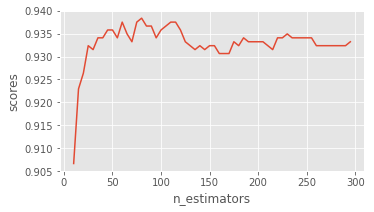

Tuned Value:  {'n_estimators': 80}


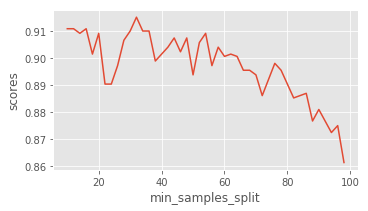

Tuned Value:  {'min_samples_split': 32}


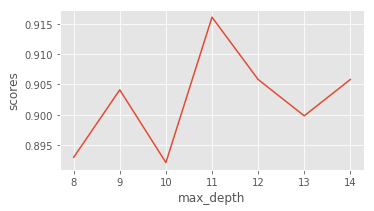

Tuned Value:  {'max_depth': 11}


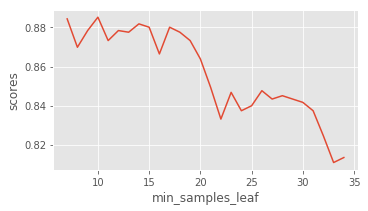

Tuned Value:  {'min_samples_leaf': 10}


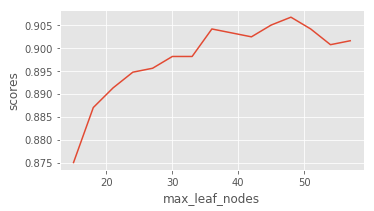

Tuned Value:  {'max_leaf_nodes': 48}


''

In [24]:
# RANDOM FOREST
fold = KFold(len(Y_train), n_folds=5, shuffle=True, random_state=5)
grid = {"n_estimators": np.arange(10, 300, 5), 
        "min_samples_split": np.arange(10, 100, 2),
        "max_depth": np.arange(8, 15, 1),
        "min_samples_leaf": np.arange(7, 35, 1),
        "max_leaf_nodes": np.arange(15, 60, 3)}
rf = RandomForestClassifier(criterion="entropy", random_state=8) # raw model

# visualizing the hyperparameters one at a time against the mean CV accuracy
index = 1
for parameter, param_range in dict.items(grid): 
    tuning_cv_plot(rf, parameter, param_range, index) # plotting-function
    index += 1
;

###### Plot insights: 
- n_estimators: initially increasing, then oscillating
- min_samples_split : generally decreasing with oscillations
- max_depth : oscillating
- min_samples_leaf : haphazard, but overall deeacrasing
- max_leaf_nodes : increasing, then becomes nearly constant with some oscillations

In [25]:
fold = KFold(len(Y_train), n_folds=5, shuffle=True, random_state=5) # 5 folds
rf = RandomForestClassifier(random_state=8, criterion="entropy", 
                            n_estimators=80, min_samples_split=32, 
                            max_depth=11, min_samples_leaf=10, 
                            max_leaf_nodes=48)
rf.fit(X_train, Y_train)
scores_rf = cross_val_score(rf, X_train, Y_train, cv=fold)
scores_rf

array([ 0.91,  0.89,  0.9 ,  0.92,  0.88])

In [26]:
# MODEL ACCURACY 

print ('Mean CV Training Accuracy: ', scores_rf.mean())
Y_pred_rf = rf.predict(X_test) # Predicted Y corresponding to X_test
print ('Testing Accuracy:', rf.score(X_test, Y_test))

Mean CV Training Accuracy:  0.902399031584
Testing Accuracy: 0.931506849315


Confusion Matrix
[[  0   3   1]
 [  0 123   6]
 [  0  10 149]]


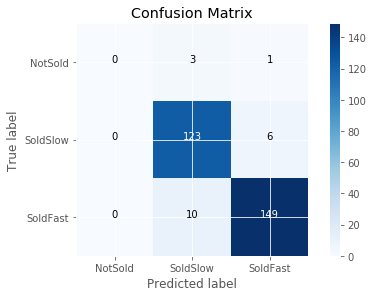

In [27]:
# CONFUSION MATRIX

cnf_matrix = confusion_matrix(Y_test, Y_pred_rf)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')

In [28]:
# EXPORTING MODEL.PKL
joblib.dump(rf, 'random_forest.pkl') 

['random_forest.pkl']

###### Final Accuracy of K Nearest Neighbors: 93.15%

##### Conclusions
- Most Accurate Model: Decision Tree Classifier
- Least Accurate Model: Nearest Neighbors
- Random Forest tuning seems quite arbitrary as most of the validation curves are quite oscilating in nature, and its difficult to tune it very finely.
- Unlike random forest classifier, it was simpler to tune the decision tree classifier to a good accuracy, as it's validation plots are not so oscillatory.
- All the confusion matrix plots show that 'NotSold' labels are always misclassified for any model, reason being there are too few datapoints(9 out of 1460) with 'NotSold' labels making the model almost impossible to learn to predict the 'NotSold' label correctly.
- The plots of the hyperparameter tuning can be observed in the previous sections

##### References
- scikit learn documentation


##### Bonus Model: DECISION TREE CLASSIFIER
- Accuracy ~ 97%
- Insightful Tree Visualization provided